1. precompute=True #Turn data augmentation on
1. Use lr_find() to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use lr_find() again
1. Train full network with cycle_mult=2 until over-fitting

In [1]:
import pandas as pd
import numpy as np
from skimage.io import imshow
from scipy.misc import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

# Read the file path and label

In [2]:
#讀取路徑檔與Label
df_train =pd.read_csv('train_index.csv')
df_test = pd.read_csv('test_index.csv')

In [3]:
df_train.columns

Index(['file_path', 'label'], dtype='object')

In [4]:
df_test.columns

Index(['0'], dtype='object')

In [5]:
class_map_from_file = pd.read_csv('target_to_number.txt', header=None)

In [6]:
class_map_from_file

,0,1
0,CALsuburb,9
1,PARoffice,7
2,bedroom,12
3,coast,10
4,forest,4
5,highway,14
6,industrial,2
7,insidecity,3
8,kitchen,0
9,livingroom,5


In [7]:
#將Label Mapping 成數字型態
class_map = {}
for i in range(class_map_from_file.shape[0]):
    class_map[class_map_from_file.loc[i,0]] = class_map_from_file.loc[i,1]
class_map

{'CALsuburb': 9,
 'PARoffice': 7,
 'bedroom': 12,
 'coast': 10,
 'forest': 4,
 'highway': 14,
 'industrial': 2,
 'insidecity': 3,
 'kitchen': 0,
 'livingroom': 5,
 'mountain': 8,
 'opencountry': 6,
 'store': 11,
 'street': 1,
 'tallbuilding': 13}

In [8]:
df_train['label'] = df_train['label'].map(class_map)

In [9]:
#Assign圖片路徑、圖片標籤、測試的圖片標籤
train_path = df_train['file_path'].values
train_label = df_train['label'].values
test_path = df_test['0'].values

In [10]:
#確認維度與數量是否正確
print(train_path.shape)
print(train_label.shape)
print(test_path.shape)

(2985,)
(2985,)
(1500,)


# Read the image

In [11]:
# Image size
sz = 299

In [12]:
#建立一個空的numpy array, shape = (圖片數, 圖片寬度, 圖片高度)
train_image = np.empty((len(train_path),sz,sz,3))

In [13]:
#依照路徑讀取圖片
for idx, path in enumerate(train_path):
    train_image[idx] = resize(imread(path, mode='RGB'), (sz,sz,3))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
#確認training set 的維度
train_image.shape

(2985, 299, 299, 3)

/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


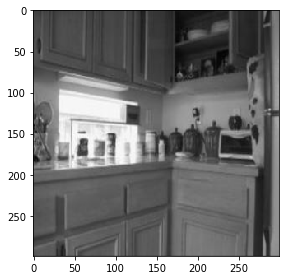

In [15]:
#看一下圖片
imshow(train_image[200])

In [16]:
#定義測試集array
test_image = np.empty((len(test_path),sz,sz,3))

In [17]:
#讀取測試集
for idx, path in enumerate(test_path):
    test_image[idx] = resize(imread(path, mode='RGB'), (sz,sz,3))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


# Seperate the train and valid dataset

In [18]:
#拆分測試集與訓練集
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_image, train_label, test_size=0.1)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Importing fast AI library

In [19]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [20]:
#指定模型存取的路徑
path= '/home/jovyan/Mid'

#參數設定
arch=resnet152
max_zoom_size = 1.1
bs=14
wd=1e-5
lr=1e-2

In [21]:
#定義data augmentation
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=max_zoom_size)
#讀取資料檔
data = ImageClassifierData.from_arrays(path=path, trn=(x_train, y_train), 
                                       val=(x_test,y_test), 
                                       tfms=tfms,
                                      test=test_image, 
                                      bs=bs,
                                      num_workers=4)

#建立訓練的模型
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 108/108 [00:26<00:00,  4.05it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 80%|████████  | 154/192 [00:01<00:00, 83.08it/s, loss=5.97]


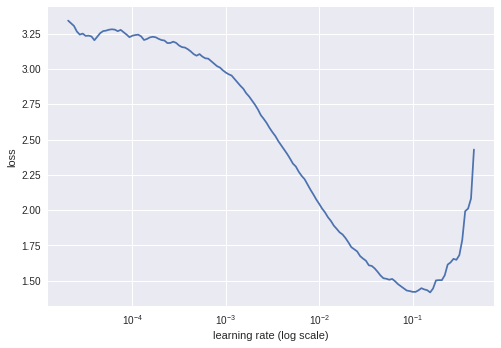

In [22]:
#找最佳的learning rate
lrf=learn.lr_find()
learn.sched.plot()

In [23]:
#建立不同的循環learning rate
learn.unfreeze()
lrs=np.array([lr/9,lr/3,lr])

learn.fit(lrs, 3, cycle_len=1, cycle_mult=3, wds=wd) #第一個是learning rate, 第二個parameter是epochs

HBox(children=(IntProgress(value=0, description='Epoch', max=13), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.596512   0.247323   0.923077  
    1      0.42871    0.168909   0.946488  
    2      0.347495   0.131063   0.963211  
    3      0.313547   0.138152   0.949833  
    4      0.375629   0.151085   0.943144  
    5      0.332934   0.160732   0.936455  
    6      0.341495   0.114868   0.9699    
    7      0.262704   0.13405    0.956522  
    8      0.262146   0.119278   0.959866  
    9      0.219517   0.120151   0.963211  
    10     0.249009   0.122617   0.953177  
    11     0.198461   0.121266   0.959866  
    12     0.203357   0.115364   0.966555  



[array([0.11536]), 0.966555174776543]

In [24]:
#將模型存起來
learn.save('224_lastlayer')
#讀取用learn.load
#learn.load('224_all')

In [38]:
#用TTA來延長測試時間，增加準確性
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs,y) ,metrics.log_loss(y, probs)

(0.9765886287625418, 0.12312852203064534)

# Prediction

In [26]:
# 使用模型進行預測
log_preds = learn.predict(is_test=True)
log_preds.shape

(1500, 15)

In [27]:
#將預測的結果轉為class
log_preds_test = np.argmax(log_preds, axis=1)
log_preds_test.shape

(1500,)

In [28]:
#將結果與對應的標籤存起來
test_list = []
for i in df_test.values:
    test_list.append(i[0][55:-4])

In [30]:
#export 成 csv 檔案
final = pd.DataFrame({'id':test_list, 'class':log_preds_test})
final.to_csv('res152.csv',index=False)